In [ ]:
# Databricks notebook source
# MAGIC %pip install -U sktime

In [15]:
#dbutils.library.restartPython()

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../libs'))
sys.path.append(os.path.abspath('../'))
#from init import spark
#from init import sc
from IPython.display import display

In [3]:
from context import initialize_context

context = initialize_context()

(context)

{'tenant_id': 'root',
 'workspace_id': 'root',
 'table_prefix': '',
 'project_id': 'project1',
 'import_id': 'import1',
 'job_id': 'job1'}

In [4]:
#from workspace import Workspace
from dataproject import DataProject
#workspace = Workspace(context["workspace_id"])
data_project = DataProject(context["project_id"])
configuration = data_project.getConfiguration()

content_clusters = [20, 60, 180, 500]

(content_clusters)

[20, 60, 180, 500]

In [5]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, lit, to_number
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import spark_partition_id, col
from pyspark.sql.types import *
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils import plotting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.trend import STLForecaster
from sktime.split import temporal_train_test_split

In [6]:
test_size = 20 # Horizon sur lequel on veut tester le modèle vs le réalisé (réel connu)
h_max = 40 # Horizon de prédiction (réel inconnu)
k = 1 # Thème à prédire (prédiction univariée)

In [7]:
# prepare data

#---- A DÉ-COMMENTER -----#

#df = spark.sql("""SELECT comp_content_clusterings.content_topic_clusters,
 # norm_content_dims.data_1,
 # comp_content_clusterings.content_topic,
 # COUNT(norm_contents.id) AS count
#FROM norm_content_dims
#JOIN norm_contents ON norm_content_dims.id = norm_contents.dim_2
#JOIN comp_content_clusterings ON norm_contents.id = comp_content_clusterings.content_id
#WHERE norm_contents.project_id = 'project1' AND
 #     norm_content_dims.project_id = 'project1' AND
  #    comp_content_clusterings.project_id = 'project1' AND
   #   dimension = 2 
#GROUP BY content_topic_clusters, content_topic, data_1""")

#df = df.select(col("data_1").alias("time"), col("content_topic").alias("class"), "count") \
 # .filter(col("content_topic_clusters") == 18).orderBy("time")
#df.show()
#Data = df.toPandas()


#---- A SUPPRIMER (AJOUT RÉMI POUR TEST) -----#

Data = pd.read_csv('data.csv')
Data = Data[Data['content_topic_clusters'] == 18]
Data = Data.rename(columns={"data_1": "time", "content_topic": "class"})
Data = Data.drop(['content_topic_clusters'], axis=1)
Data.head()

,time,class,count
1,2023-02-27,7,2
6,2023-01-21,0,4
8,2023-03-24,4,1
9,2023-10-31,0,1
11,2023-01-31,4,24


In [14]:
Data['time'] = pd.to_datetime(Data['time'], format="%Y-%m-%d") # On déclare le format date
Data = Data.set_index('time').groupby('class').resample('D').asfreq() # On génère les dates manquantes
Data = Data.drop(columns = 'class') # On drop la colonne class qui est maintenant en index
Data = Data.fillna(0) # On remplit les dates manquantes avec des zéros

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='count'>)

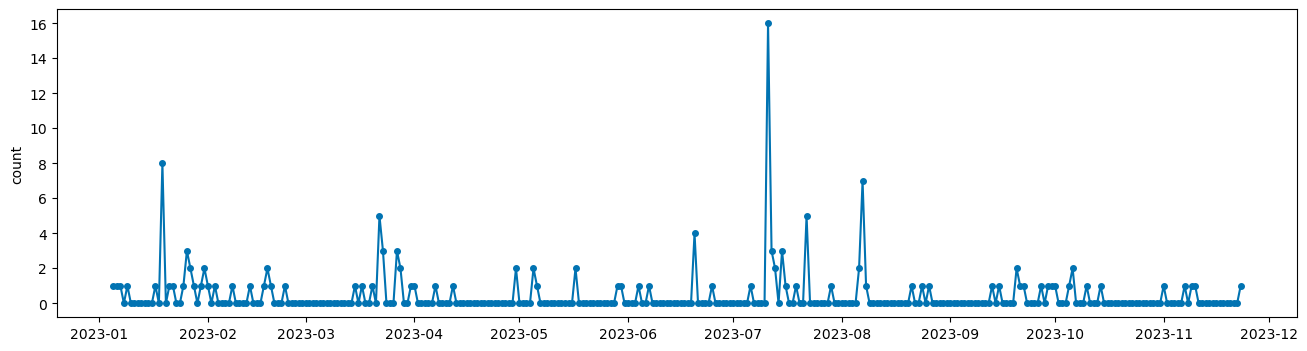

In [15]:
# Représenter une série k parmi les K classes. 
## k est fixé dans le code plus haut et pourrait être choisi par l'utilisateur

Data_plot = Data[Data.index.get_level_values('class')==k].reset_index(level='class', drop=True)
plot_series(Data_plot)

In [16]:
# Le modèle est entrainé sur une fraction de la série (train set) et testé sur le reste (test set)
y_train, y_test = temporal_train_test_split(Data, test_size=test_size) # On split le jeu de données

In [20]:
# On va entrainer un Auto ETS sur l'ensemble du panel

fh = np.arange(1, h_max) # Forecasting Horizon

forecaster = AutoETS(sp = 7, error = "add", trend = None, seasonal = "add")  #Model

y_pred = forecaster.fit(y_train, fh=fh).predict() # Point forecast

y_pred_ints = forecaster.predict_interval(coverage=0.9) # Prediction intervals

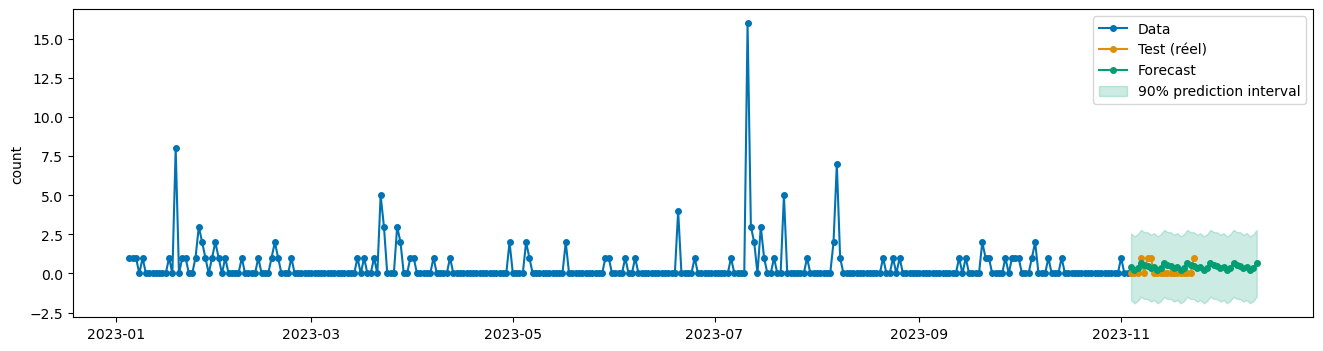

In [21]:
# Une fois le modèle entrainé et les forecasts calculés, on peut les afficher classe par classe

class_to_plot = 1 # On choisit la catégorie à afficher

fig, ax = plotting.plot_series(
    y_train.xs(class_to_plot, level='class'), y_test.xs(class_to_plot, level='class'), y_pred.xs(class_to_plot, level='class'),
    labels=["Data", "Test (réel)", "Forecast"],
    pred_interval=y_pred_ints.xs(class_to_plot, level='class')
)
ax.legend();

In [ ]:
# TODO generate forecasts

In [ ]:
spark.sql(f"""
    DELETE FROM comp_forecasting
    WHERE project_id='{context["project_id"]}' AND
          content_group='{context["import_id"]}'
""")

topics = reduce(DataFrame.unionAll, [summary for content_cluster, summary in summaries.items()])

topics.writeTo(f"""comp_forecasting""").using("delta").append()

display(topics)